# Single Integral Comparison 3
*David Thomas 2017/03/29*

Numerical Integration:

\begin{align*}
\mathcal{L}(L_{obs}|\alpha, S, \sigma_{obs}, z) &= \iint\ dLdM\ P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)\\
&= \sum_{M=min(MP)}^{max(MP)}\sum_{L = min(L_{obs})}^{max(L_{obs})}\ \Delta_M\Delta_L\ P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)\\
\end{align*}

Simple Monte Carlo:

\begin{align*}
\mathcal{L}(L_{obs}|\alpha, S, \sigma_{obs},z) &= \iint dLdM\ P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)\\
&= \frac{1}{N_s}\sum_{M \sim\ P(M|z)}\sum_{L \sim\ P(L|M, \alpha, S, z)} P(L_{obs}|L, \sigma_{obs})\\
\end{align*}

Importance Sampling:

\begin{align*}
\mathcal{L}(L_{obs}|\alpha, S, \sigma_{obs},z,c) &= \iint dLdM \frac{P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)Q(L|L_{obs}, \sigma_{obs})Q(M|L,\alpha, S, z, c)}{Q(L|L_{obs}, \sigma_{obs})Q(M|L,\alpha, S, z, c)}\\
&= \frac{1}{N_s}\sum_{(M,L) \sim\ (Q(M|L,\alpha, S, z, c), Q(L|L_{obs}, \sigma_{obs}))}\frac{P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)}{Q(L|L_{obs}, \sigma_{obs})Q(M|L,\alpha, S, z, c)}\\
\end{align*}

In [136]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rc
from bigmali.grid import Grid
from bigmali.likelihood import BiasedLikelihood
from bigmali.prior import TinkerPrior
from bigmali.hyperparameter import get
from scipy.stats import lognorm
from time import time
rc('text', usetex=True)

data = pd.read_csv('/Users/user/Code/PanglossNotebooks/MassLuminosityProject/mock_data.csv')

prior = TinkerPrior(Grid())

def p1(lobs, lum, sigma):
    return fast_lognormal(lum, sigma, lobs)

def p2(lum, mass, a1, a2, a3, a4, S, z):
    mu_lum = np.exp(a1) * ((mass / a3) ** a2) * ((1 + z) ** (a4))
    return fast_lognormal(mu_lum, S, lum)
    
def p3(mass, z):
    return prior.fetch(z).pdf(mass)

def logp1(lobs, lum, sigma):
    return fast_log_lognormal(lum, sigma, lobs)

def logp2(lum, mass, a1, a2, a3, a4, S, z):
    mu_lum = np.exp(a1) * ((mass / a3) ** a2) * ((1 + z) ** (a4))
    return fast_log_lognormal(mu_lum, S, lum)

def logp3(mass, z):
    return prior.fetch(z).logpdf(mass)

def q1(lum, lobs, sigma):
    return fast_lognormal(lobs, sigma, lum)
    
def q2(mass, lum, a1, a2, a3, a4, S, z):
    mu_mass = a3 * (lum / (np.exp(a1) * (1 + z) ** a4)) ** (1 / a2)
    return fast_lognormal(mu_mass, S, mass)

def midpoints(arr):
    n = len(arr)-1
    ret = np.zeros(n)
    for i in xrange(n):
        ret[i] = (arr[i+1] + arr[i]) / 2.
    return ret

def fast_lognormal(mu, sigma, x):
    return  (1/(x * sigma * np.sqrt(2 * np.pi))) * np.exp(- 0.5 * (np.log(x) - np.log(mu)) ** 2 / sigma ** 2)

def fast_log_lognormal(mu, sigma, x):
    return  -np.log(x * sigma * np.sqrt(2 * np.pi)) - 0.5 * (np.log(x) - np.log(mu)) ** 2 / sigma ** 2

def log10(arr):
    return np.log(arr) / np.log(10)

In [219]:
ind = 0
true_mass = data.ix[ind]['mass']
true_z = data.ix[ind]['z']
true_lum = data.ix[ind]['lum']
true_lum_obs = data.ix[ind]['lum_obs']
true_lum_obs_collection = data.lum_obs

In [123]:
print log10(true_lum_obs)

3.93110625126


In [71]:
def numerical_integration(a1, a2, a3, a4, S, nsamples=10**3):
    masses = midpoints(prior.fetch(true_z).mass[1:])
    delta_masses = np.diff(prior.fetch(true_z).mass[1:])
    lums_tmp = np.logspace(log10(np.min(data.lum_obs)), log10(np.max(data.lum_obs)), nsamples)
    lums = midpoints(lums_tmp)
    delta_lums = np.diff(lums_tmp)
    integral = 0
    for i,lum in enumerate(lums):
        integral += np.sum(delta_masses * delta_lums[i] * p1(true_lum_obs, lum, sigma) * \
            p2(lum, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z))
    return integral

In [72]:
def simple_monte_carlo_integration(a1, a2, a3, a4, S, nsamples=10**6):
    masses = prior.fetch(true_z).rvs(nsamples)
    mu_lum = np.exp(a1) * ((masses / a3) ** a2) * ((1 + true_z) ** (a4))
    lums = lognorm(S, scale=mu_lum).rvs()
    return np.sum(p1(true_lum_obs, lums, sigma)) / (nsamples)

In [243]:
def importance_sampling_integration(a1, a2, a3, a4, S, nsamples=10**6):
    rev_S = 5.6578015811698101 * S
    lums = lognorm(sigma, scale=true_lum_obs).rvs(size=nsamples)
    mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
    masses = lognorm(rev_S, scale=mu_mass).rvs()
    integral = np.sum((p1(true_lum_obs, lums, sigma) * \
            p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)) / \
                (q1(lums, true_lum_obs, sigma) * q2(masses, lums, a1, a2, a3, a4, rev_S, true_z))) /\
            len(lums)
    return integral

In [220]:
a1,a2,a3,a4,S = get()
sigma = 0.05
rev_S = 5.6578015811698101 * S

print numerical_integration(a1,a2,a3,a4,S,nsamples=10**4)
print simple_monte_carlo_integration(a1,a2,a3,a4,S,nsamples=10**5)
print importance_sampling_integration(a1,a2,a3,a4,S,nsamples=10**5)

1.16445343689e-05
1.73167080169e-06
1.16407059161e-05


In [221]:
from scipy.optimize import minimize

In [222]:
def neg_log_integrand(prms):
    mass, lum = np.exp(prms)
    return \
    - logp1(true_lum_obs, lum, sigma) \
    - logp2(lum, mass, a1, a2, a3, a4, S, true_z) \
    - logp3(mass, true_z)

In [223]:
x0 = [np.log(10**11), np.log(10**4.0)]
ans = minimize(neg_log_integrand, x0, method='BFGS')
print ans

      fun: 44.67666544656812
 hess_inv: array([[ 0.09040289,  0.00303158],
       [ 0.00303158,  0.00237168]])
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 5
     njev: 9
   status: 0
  success: True
        x: array([ 25.7028592 ,   9.51195289])


In [224]:
neg_log_integrand(ans['x'])

44.676665446568123

In [227]:
import math
h = np.linalg.inv(ans['hess_inv'])
h[0,0] = h[0,0] * (1/np.exp(ans['x'][0])) ** 2
h[1,0] = h[1,0] * (1/np.exp(ans['x'][0])) * (1/np.exp(ans['x'][1]))
h[0,1] = h[1,0]
h[1,1] = h[1,1] * (1/np.exp(ans['x'][1])) ** 2
np.exp(-44.67666544656812) * math.sqrt((2 * np.pi) ** 2/ np.linalg.det(h))

6.999302758488218e-06

### Laplace Approximation

Let 
$$f(M,L) = \ln P(L_{obs}|L, \sigma_{obs}) + \ln P(L|M, \alpha, S, z) + \ln P(M|z)$$

Then we use a Quasi-Newton method to solve 

$$\ln M_{opt},\ln L_{opt}, H_{ln\ opt}^{-1} = \text{argmin}_{\ln M,\ln L} -\left[f(M,L)\right]$$

where we optimize over logarithmic mass and luminosity because otherwise the numerical disparity between mass and luminosity leads to an inaccurate diagonal hessian. Then by the chain rule we have 

$$-\frac{\partial^2 f}{\partial M \partial L} = -\frac{\partial^2 f}{\partial \ln M \partial \ln L} \frac{\partial \ln M}{\partial M} \frac{\partial \ln L}{\partial L} = -\frac{1}{ML}\frac{\partial^2 f}{\partial \ln M \partial \ln L}$$

Hence our desired Hessian is

$$H_{opt} = (H_{ln\ opt}^{-1})^{-1} \odot \begin{pmatrix}M_{opt}^{-2} & M_{opt}^{-1}L_{opt}^{-1}\\ M_{opt}^{-1}L_{opt}^{-1} & L_{opt}^{-2} \end{pmatrix}$$

where $\odot$ is elementwise multiplication. Then we can approximate the likelihood as 

$$\mathcal{L}(L_{obs}|\alpha, S, \sigma_{obs}, z) = \exp(f(M_{opt}, L_{opt}))\sqrt{\frac{(2\pi)^2}{\det(H_{opt})}}$$

To test this approximation we can also see how well $f(M,L)$ is approximated by its Gaussian approximation

$$f(M_{opt}, L_{opt})\exp(\frac{-1}{2}((M,L) - (M_{opt}, L_{opt}))^T H((M,L) - (M_{opt}, L_{opt}))$$

In [209]:
np.linalg.inv(ans['hess_inv']) * (1/ans['x'][0])* (1/ans['x'][1])

array([[ 0.05102133, -0.06698233],
       [-0.06698233,  2.0064557 ]])

In [ ]:
Todo, look at approximation

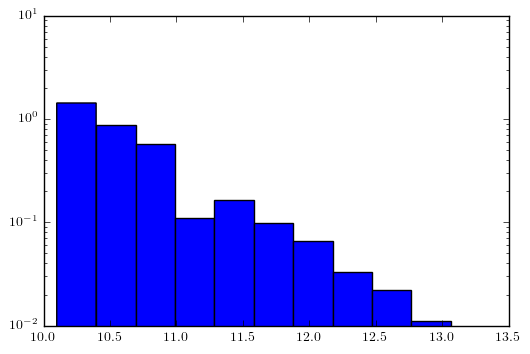

In [242]:
dm = data.mass[data.z < 0.1].as_matrix()
mmin = dm.min()
mmax = dm.max()
plt.hist(np.log(dm) / np.log(10), normed=True)
space = np.linspace(mmin, np.log(mmax) / np.log(10), 1000)
vals = prior.fetch(0).pdf(space)
# plt.plot(space, vals)
plt.subplot
plt.gca().set_yscale('log')
